## Chapter 15: Recurrent networks 

# 15.2  Dynamic Systems *without* memory

In this Section we introduce the concept of *recurrent networks*, which are the natural extension of what we have discussed thus far for dealing with *ordered data*.  

In [1]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
from mlrefined_libraries import recurrent_library as recurlib

# demos for this notebook
regress_plotter = nonlib.nonlinear_regression_demos
static_plotter = optlib.static_plotter.Visualizer()
basic_runner = nonlib.basic_runner
datapath = '../../mlrefined_datasets/recurrent_datasets/'

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# import timer
from datetime import datetime 
import copy
import matplotlib.pyplot as plt
from matplotlib import gridspec

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 15.2.1  The simplest dynamic system

When we saw that a set of input data points $x_1,\,x_2,...,x_P$ is *ordered*, what do we mean?  Well in plain English we just mean that the point $x_1$ comes before $x_2$, the point $x_2$ comes before $x_3$, and so on.  The simplest way to say this in the language of math is to say that the point $x_2$ follows the point $x_1$ by being passed through (or 'plugged into') a function $f\left(\cdot\right)$ as

\begin{equation}
x_{2} = f\left(x_{1}\right).
\end{equation}

Likewise  $x_3$ follows $x_2$ by being passed through the function function $f$ likewise as

\begin{equation}
x_{3} = f\left(x_{2}\right).
\end{equation}

And likewise, in general we can say that the point $x_p$ follows the point $x_{p-1}$ mathematically as

\begin{equation}
x_{p} = f\left(x_{p-1}\right) 
\end{equation}

for p = 2,...,P.

Here we have translated 'order' to mean that each and every point is dependent only on its direct predecessor, all via a single function $f$ (which could be a traditional mathematical, or computational function).  This is the simplest translation - mathematically speaking - of the notion that our points $x_1$ through $x_P$ are ordered, but it is by no means the only translation.  

Nonetheless this simple description is one of the most common ways of modeling ordered data used today, and it goes by a large number of names (as variants of it are studied in virtually every area of science / engineering / mathematics) - including the names *discrete dynamic system*, a *discrete dynamical system*, a *recurrence relation*, a *difference equation*, a *complex system*, and the list goes on...  In the context of machine learning - for reasons we will detail below - we will refer to this as a *dynamic system without memory* or at times just a *dynamic system* for short. 

Lets take a look at a few famous examples of this simple dynamic system.

#### <span style="color:#a50e3e;">Example 1. </span>  Exponential growth modeling

A sequence of inputs $x_1,...,x_P$ grows *linearly* if it obeys the simple dynamic system below

\begin{equation}
\begin{array}
\
x_1 = \gamma \\
x_{p} = w_0 + w_1x_{p-1}   
\end{array}
\end{equation}

where $\gamma$, $w_0$, and $w_1$ are constants.  Here the function $f$ is *linear*, and given by $f\left(x\right) = w_0 + w_1x$.  With dynamical systems the value assigned to $x_1 = \gamma$ is referred to as the *initial condition*, and its setting can significantly change the trajectory of a sequence generated by such a system (as can the parameters of the update formula).  

Below we show two example sequences of length $P = 10$.  In the first, shown in the left panel below, we set the initial condition $x_1 = 2$ and $w_0 = 0$ and $w_1 = 2$.  Note while each point in the sequence increases *linearly* from step to step, the data overall is increasing exponentially upwards.  In the right panel we use an initial condition of $x_1 = 1$ with $w_0 = -2$ and $w_1 = 2$.  This data - while decreasing linearly at each step - globally is decreasing exponentially.

<IPython.core.display.Javascript object>


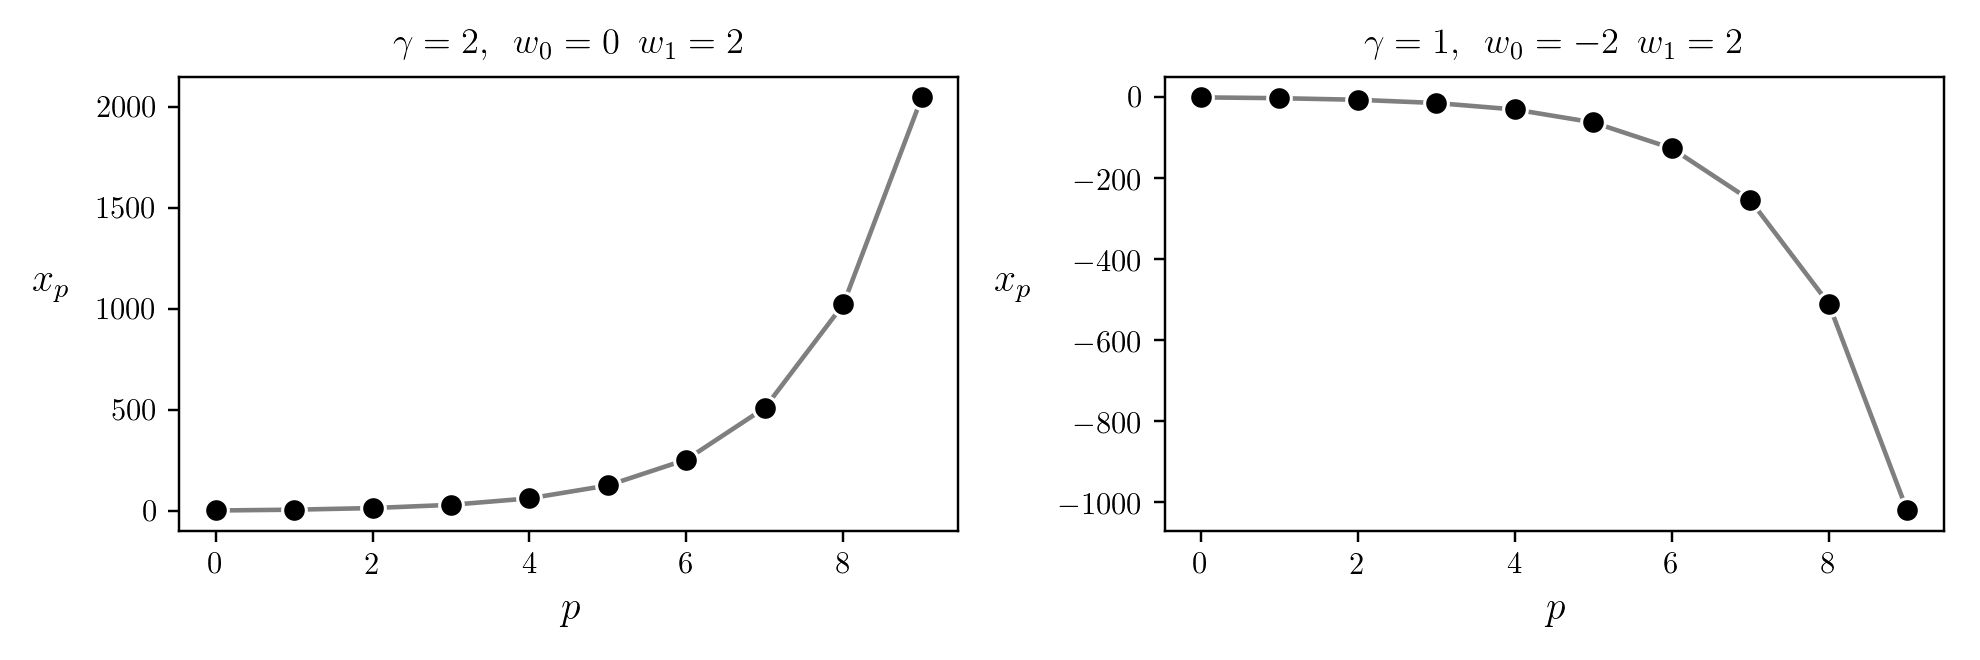

In [69]:
## This code cell will not be shown in the HTML version of this notebook
# function for linear growth
def linear_growth(x):
    return w_0 + w_1*x

# create a logistic sequence via for loop
num_elements = 10              # number of points to generate
sequence1 = []                 # container for generated points
x = 2                          # our initial point
w_0 = 0; w_1 = 2;
for i in range(num_elements):
    x = linear_growth(x)
    sequence1.append(x)
    
sequence2 = []                 # container for generated points
x = 1                          # our initial point
w_0 = -2; w_1 = 2;
for i in range(num_elements):
    x = linear_growth(x)
    sequence2.append(x)
    
### plot the result ###
fig = plt.figure(figsize = (9,3))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1]) 
ax1 = plt.subplot(gs[0]);
ax2 = plt.subplot(gs[1]); 

ax1.scatter(np.arange(len(sequence1)),sequence1,c = 'k',edgecolor = 'w',s = 60,linewidth = 1,zorder = 3);
ax2.scatter(np.arange(len(sequence2)),sequence2,c = 'k',edgecolor = 'w',s = 60,linewidth = 1,zorder = 3);
ax1.plot(sequence1,alpha = 0.5,c = 'k');
ax2.plot(sequence2,alpha = 0.5,c = 'k');  # plot lines connecting consecutive points for visualization purposes

# label axes
ax1.set_xlabel(r'$p$',fontsize = 13)
ax1.set_ylabel(r'$x_p$',fontsize = 13,rotation = 0,labelpad = 15)
ax1.set_title(r'$\gamma = 2,\,\,\,w_0 = 0\,\,\,w_1 = 2$')
ax2.set_xlabel(r'$p$',fontsize = 13)
ax2.set_ylabel(r'$x_p$',fontsize = 13,rotation = 0,labelpad = 15)
ax2.set_title(r'$\gamma = 1,\,\,\,w_0 = -2\,\,\,w_1 = 2$')

This kind of dynamic system is precisely what we use when calculating *compound interest* on a loan.  For example, the run shown in the left panel above (could be interpreted (if we suppose $p$ has a unit of weeks and $x_p$ dollars) as showing the total amount owed on a loan of $x_1 = \$2$ at an interest rate of $100\%$ ($w_1 = 2$) per week over the period of $10$  weeks.  This kind of ridiculous high interest loan is often made by 'loansharks' in the movies, and by predatory 'payday loan' shops in the real world.

More generally the formula for compound interest (when none of the principal or interest is repaid at each period) on an initial loan of $x_1$ dollars is a version of the linear growth model above

\begin{equation}
x_p = \left(1 + \text{interest rate}\right)x_{p-1}.
\end{equation}

In other words, it is the exponential growth model with $w_0 = 0$ and $w_1 = \left(1 + \text{interest rate}\right)$.

This sort of model is also used as a simple model for uncapped *population growth*.  For example, suppose a single species of creature (bacteria, bunny rabbits, humans, whatever) live alone on a planet that has an infinite amount of space, resources, etc.,  Suppose at the start of the universe there are $2$ creatures, and after each period of time (e.g., a day) they reproduce at a rate of $100\%$.  Since there are infinite resources in this universe they can go on reproducing forever, reproducing at an exponential rate.  This scenario can also be interpreted as the example in the left panel above (where $x_1 = 2$ denotes the initial number of creatures and $w_1 = 2$ the growth rate).  

Just like compound interest, the uncapped population growth model falls into the same kind of framework as we saw above as

\begin{equation}
x_p = \left(\text{growth rate per period}\right)x_{p-1}.
\end{equation}

In other words, it is the exponential growth model with $w_0 = 0$ and $w_1 = \left(1 + \text{growth rate per period}\right)$.

#### <span style="color:#a50e3e;">Example 2. </span>  Logistic growth and chaotic systems

In this example we illustrate several examples of input data generated via the classical *logistic system*, defined as follows

\begin{equation}
\begin{array}
\
x_1 = \gamma \\
x_{p} = w x_{p-1}\left(1 - x_{p-1} \right).
\end{array}
\end{equation}

In other words, this is a dynamic system with update function  $f\left(x\right) = wx\left(1 - x\right)$.

It is called a *logistic system* because (like *logistic functions themselves*) it arises in the modeling of population growth under the assumption that resources in an environment are limited.  The modeling idea is basically this: if $x_p$ denotes the population of a single species of creature (e.g., bacterium, bunny rabbits, humans, whatever) in a closed system with a maximum amount of space / resources the growth rate of a population cannot follow the exponential rate detailed in the previous example forever.  In the beginning, when there are not too many of the creatures, the growth can indeed be exponential - thus the first part of the equation above $wx_{p-1}$ (the exponential growth we saw previously).  But at a certain point, when space and resources become limited, competition for survival causes the growth rate to slow down.  Here this concept is modeled by the second portion of the equation above: $\left(1 - x_{p-1}\right)$.  Here $1$ denotes the maximum population permitted by the limited resources of the environment (this could be set to some other number, but for simplicity we have left it at $1$).  As the population $x_p$ approaches this maximum level this second term tempers the exponential growth pursued by the first term, and the population levels off.  

For the right settings we can generate our familiar logistic 's' shape curve - as shown below for $P = 30$ points using an initialization of $x_1 = 10^{-4}$ and $w = 1.75$.

<IPython.core.display.Javascript object>


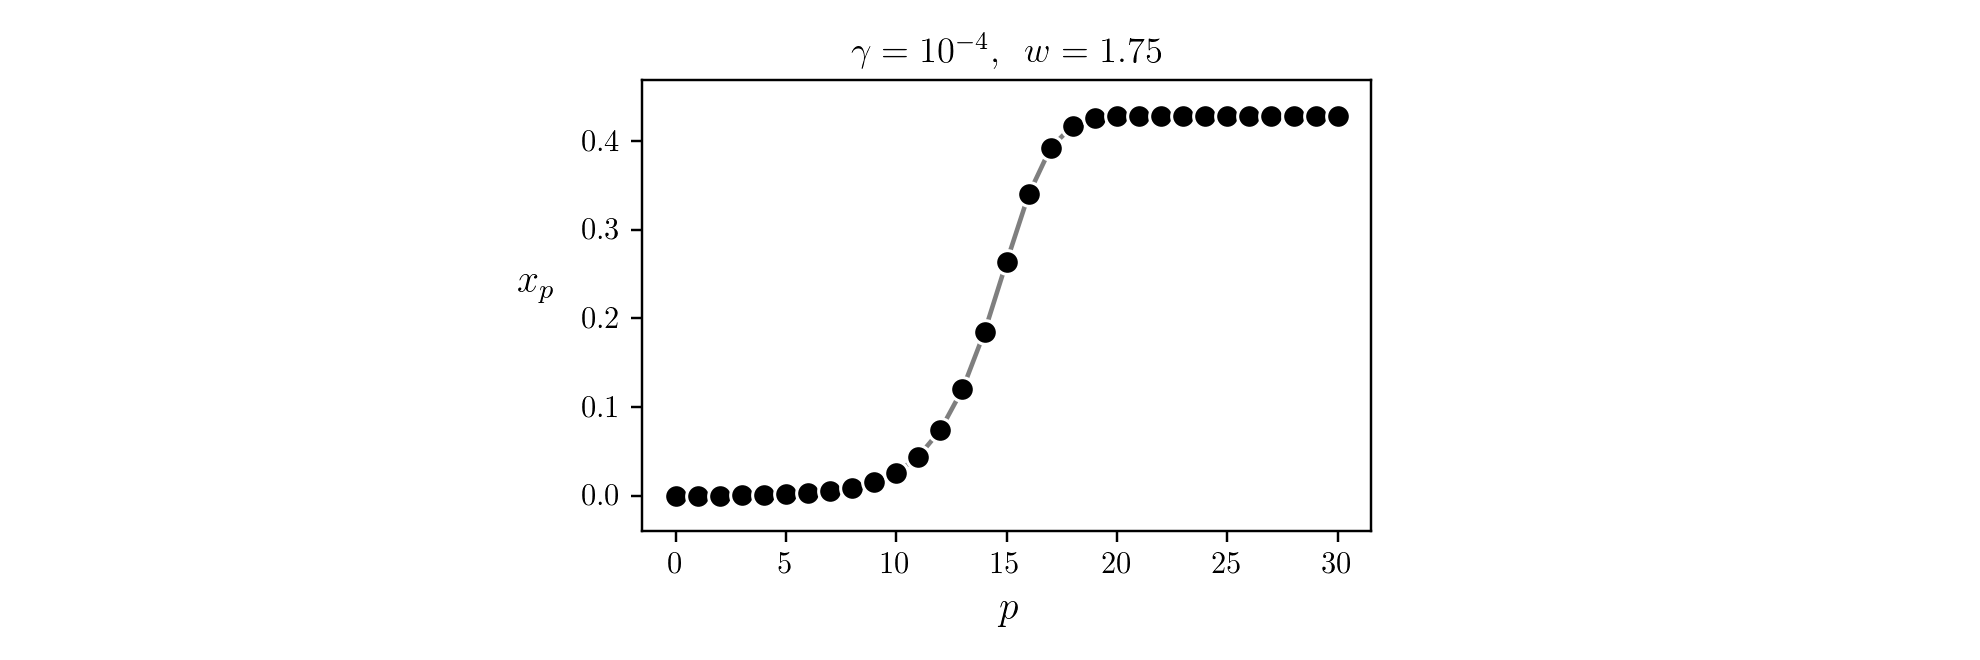

In [91]:
## This code cell will not be shown in the HTML version of this notebook
# logistic function
def logistic(x,w):
    return w*x - w*x**2

# we could use a for loop, but lets define 
# the logistic system programmatically
def f(x,w,n,seq):  # x = input point, n = desired number of compositions
    seq.append(x)
    if n > 1:
        return f(w*x - w*x**2,w,n-1,seq)
    else:
        seq.append(w*x - w*x**2)
        return seq
    
# create the same sequences using our recursive definition of the logistic system
sequence1 = f(0.0001,1.75,30,[]); 

# plot the result
fig = plt.figure(figsize = (9,3))
gs = gridspec.GridSpec(1, 3, width_ratios=[1,2,1]) 
ax = plt.subplot(gs[0]); ax.axis('off')
ax1 = plt.subplot(gs[1]); 
ax2 = plt.subplot(gs[2]); ax2.axis('off')

ax1.scatter(np.arange(len(sequence1)),sequence1,c = 'k',edgecolor = 'w',s = 60,linewidth = 1,zorder = 3);
ax1.plot(sequence1,alpha = 0.5,c = 'k');

# label axes
ax1.set_xlabel(r'$p$',fontsize = 13)
ax1.set_ylabel(r'$x_p$',fontsize = 13,rotation = 0,labelpad = 15)
ax1.set_title(r'$\gamma = 10^{-4},\,\,\,w = 1.75$')

This dynamic system is often *chaotic* (being a prime exemplar in *chaos theory*) because slight adjustments to the initial condition and weight $w$ can produce drastically different sequences of data.  For example, below we show two sequences of length $P = 70$ generated via the system above.  In the left panel we have set the initial condition $\gamma = 10^{-4}$ and $w = 3$, and in the right we use the same initial condition and $w = 4$.  As you can see the form taken by the two resulting sequences is drastically different.  In the case on the left the resulting sequence converges nicely, while the latter sequence bounces around crazily (and will do so forever).  In fact the sequence on the right is *almost* random, a fact that [can be proven mathematically]([https://www.complexityexplorer.org/courses/22-introduction-to-dynamical-systems-and-chaos-winter-2015]).

<IPython.core.display.Javascript object>


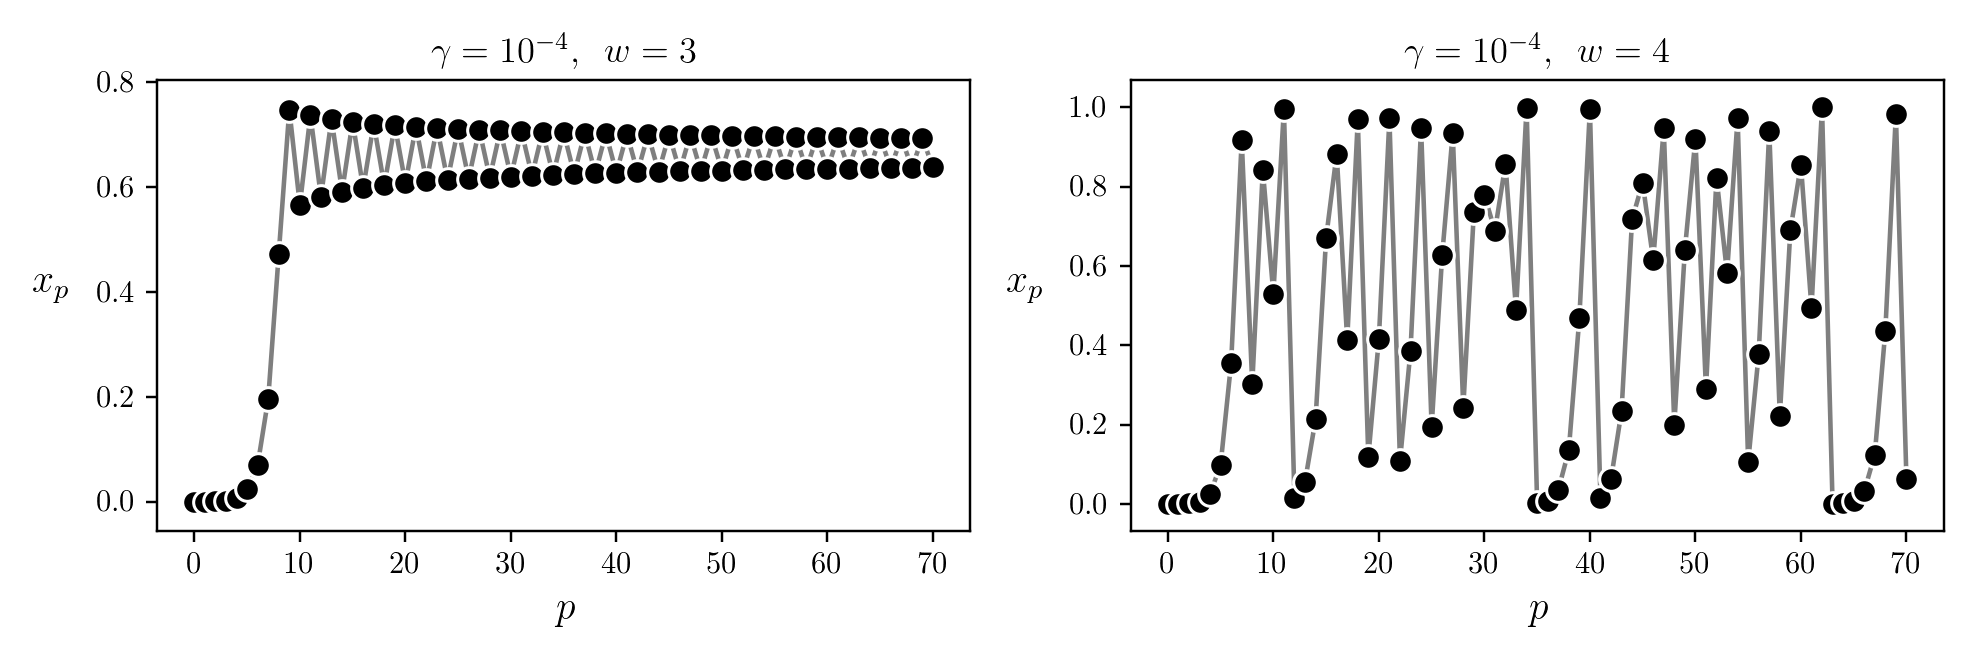

In [92]:
## This code cell will not be shown in the HTML version of this notebook
# create the same sequences using our recursive definition of the logistic system
sequence1 = f(0.0001,3,70,[]); sequence2 = f(0.0001,4,70,[]);

# plot the result
fig = plt.figure(figsize = (9,3))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1]) 
ax1 = plt.subplot(gs[0]);
ax2 = plt.subplot(gs[1]); 

ax1.scatter(np.arange(len(sequence1)),sequence1,c = 'k',edgecolor = 'w',s = 60,linewidth = 1,zorder = 3);
ax2.scatter(np.arange(len(sequence2)),sequence2,c = 'k',edgecolor = 'w',s = 60,linewidth = 1,zorder = 3);
ax1.plot(sequence1,alpha = 0.5,c = 'k');
ax2.plot(sequence2,alpha = 0.5,c = 'k');  # plot lines connecting consecutive points for visualization purposes

# label axes
ax1.set_xlabel(r'$p$',fontsize = 13)
ax1.set_ylabel(r'$x_p$',fontsize = 13,rotation = 0,labelpad = 15)
ax1.set_title(r'$\gamma = 10^{-4},\,\,\,w = 3$')

ax2.set_xlabel(r'$p$',fontsize = 13)
ax2.set_ylabel(r'$x_p$',fontsize = 13,rotation = 0,labelpad = 15)
ax2.set_title(r'$\gamma = 10^{-4},\,\,\,w = 4$')

## 15.2.3  The order of a dynamic system

In the first Subsection above we translated the notion that the sequence of points $x_1,\,x_2,...,x_P$ is ordered mathematically into 

\begin{equation}
x_{p} = f\left(x_{p-1}\right) 
\end{equation}

i.e., that each point (after the initial condition $x_1$ is based entirely off its direct predecessor.  More generally we can translate the 'ordered' notion to mean that every point is derived from its previous $\mathcal{O} \geq 1$ predecessors as

\begin{equation}
x_{p} = f\left(x_{p-1},\,x_{p-2},\,...,x_{p-\mathcal{O}}\right)   
\end{equation}

for $p = \mathcal{O},...,P$.  This value $\mathcal{O}$ is often called the *order* of a dynamic system.  So for example, the instances detailed in the previous Subsections all have order $1$.  

Notice that a general order $\mathcal{O}$ dynamic system must have $\mathcal{O}$ initial conditions, since in order to generate the first point $x_\mathcal{O}$ all previous values $x_{\mathcal{O}-1} = \gamma_{\mathcal{O}-1}$ through $x_1 = \gamma_1$ must already be set (or 'initialized').  

#### <span style="color:#a50e3e;">Example 3. </span>  The Fibonachi Sequence

A classic example of a dynamic system of order $\mathcal{O} = 2$ is the 

\begin{equation}
\begin{array}
\
x_1 = 0 \\
x_2 = 1 \\
x_{p} = x_{p-1} + x_{p-2}
\end{array}
\end{equation}

This sequence naturally creates a 'golden spiral' like the one shown below ([image credit](https://www.geeksforgeeks.org/program-for-nth-fibonacci-number/)).



<figure>
<p>
<img src= '../../mlrefined_images/recurrent_images/fibonacci_sequence.png' width="40%" height="40%" alt=""/>
</p>
<figcaption> <strong>Figure 1:</strong> <em> The geometry of the Fibonachi defines the so-called 'golden spiral'.

</em>
</figcaption>
</figure>

## 12.5.5  Markov chains: stochastic dynamic systems without memory

Written text is commonly modeled as a dynamic system without memory.  For example, take the simple sentence shown in the animation below "my dog runs".  Each *word* in this sentence does - intuitively - seem to follow its predecessor in an orderly, functional, and predictable way.  In the animation below we walk through the sentence word-by-word, highlighting the fact that each word follows its immediate predecessor just like a $\mathcal{O}=1$ dynamic system.  

<figure>
<p>
<img src= '../../mlrefined_images/recurrent_images/dog1.gif' width="50%" height="50%" alt=""/>
</p>
<figcaption> <strong>Figure 2:</strong> <em> Each word in a simple English sentence follows its predecessor in an orderly, functional, and predictive fashion - much like an order $\mathcal{O}=1$ dynamic system.
</em>
</figcaption>
</figure>

This kind of intuitive leap makes sense more generally as well.  We can also think of each word in a sentence following logically based not just on its immediate predecessor, but several words just like an order $R$ dynamic system.  Text certainly is generally structured like this - with preceding words in sentence determining those that follow. 

However while text certainly seems to have the structure of a dynamic system like the ones we have seen thus far, it does have one attribute that we have not seen thus far: choice. A given word does not always completely determine the word that follows it.   For example, in the sentence above we could imagine a range of words following the word "dog" instead of "runs", like e.g., "eats".  This would give us the sentence "my dog eats" instead of "my dog runs", which is a perfectly valid and meaningful English sentence.  Of course there are other words that could follow "dog" as well, some of which like e.g., the word "sighs" that while valid would be less common than "eats".  However some words, like e.g., "dracula", making the sentence "my dog dracula" do not make any sense at all.

<figure>
<p>
<img src= '../../mlrefined_images/recurrent_images/dog2.gif' width="50%" height="50%" alt=""/>
</p>
<figcaption> <strong>Figure 3:</strong> <em> Many words could potentially follow the word "dog" in this sentence.  However some words - like "runs" or "eats" - are far more likely than others like "sighs".  Further, some words like e.g., "dracula" do not make any sense.
</em>
</figcaption>
</figure>

So in summary, while a valid sentence of English words clearly has *ordered* structure like a dynamic system, with each word following its predecessor, there are often many *choices* for subsequent words (unlike the dynamic systems we have seen previously).  Moreover of the choices following a particular word we can reasonably say that some are more likely to occur than others.  In other words, these choices are *stochastic* in nature (*stochastic* means *choices*) - with each having a different probability of occurring.  For example, below we show the four choices of words following "dog" in the sentence above assigning (using our intuition) a probability of occurring to each.  Here we suppose the word "runs" is the most probable, "eats" the next, and so on.  

<figure>
<p>
<img src= '../../mlrefined_images/recurrent_images/dog3.png' width="60%" height="60%" alt=""/>
</p>
<figcaption> <strong>Figure 4:</strong> <em> Here we show the selection of words from Figure 3 that could possibly follow the word "dog", along with a probability $p$ of the word occurring (which here we set ourselves via intuition).  In this case the word "eats" has the highest probability of occurring after "dog", then "runs", and so on.  The probabilities do not add up to $1$ because there are other words that could reasonably follow "dog" that we do not list here.
</em>
</figcaption>
</figure>

The probabilities shown do not add up to $1$ because there could be other reasonable words that could follow "dog" other than those shown here.  To more accurately estimate these probabilities - and to identify all of the other possible words that follow "dog" - it is common to take a large body of text (like e.g., a long book), scan it for all occurrences of the word "dog" and make a listing of all the words following it along with their frequency.  Then to create a sample probability for each - so that the sum of the probabilities adds up to $1$ - we simply divide off the total number of times "dog" appeared in the text (often referred to as a *corpus*).

Irregardless of how we compute the probabilities, mathematically speaking we codify the list possible outputs and their probability of occurrence - like the list of possible words shown above following "dog" - as a *histogram* (which is often also called a *probability mass function*).  This is just a mathematical function with many possible outputs to a single input, each weighted with its respective probability $\mathscr{p}$.  For example, we can formally write the histogram of possible outputs of words following "dog" as

\begin{equation}
\text{histogram}\left(\text{"dog"}\right) = 
\begin{cases}
\text{"runs"} \,\,\,\,\,\,\,\,\,\,\,\, \text{with probability} \,\,\,\mathscr{p} = 0.4 \\
\text{"eats"} \,\,\,\,\,\,\,\,\,\,\,\,\, \text{with probability} \,\,\,\mathscr{p} = 0.3 \\
\text{"sighs"} \,\,\,\,\,\,\,\,\,\, \text{with probability} \,\,\,\mathscr{p} = 0.05 \\
\text{"dracula"} \,\,\,\,\, \text{with probability} \,\,\,\mathscr{p}= 0 \\
\vdots
\end{cases}
\end{equation}

Here in each case '$p$' stands for the *probability* of the corresponding word occurring.  Our prediction for the next word in the sentence is then simply the one that is most valuable, or the one with the largest probability.  Here suppose that word is "runs".  Translating this statement into math, we predict the word following "dog" by taking the $\text{argmax}$ over all of the choices above as

\begin{equation}
\text{(word we predict to follow "dog")} \,\,\,\,\, \text{"runs"} = \underset{\mathscr{p}}{\text{argmax}}\,\,\,\, \text{historgram}\left(\text{"dog"}\right).
\end{equation}

More generally, if we denote by $x_{p-1}$ the $\left(p-1\right)^{th}$ word in a sentence, and $u$ any particular word than the probability $\mathscr{p}$ above of $x_p$ occuring (following $x_{p-1}$) (often called the *transition probability*) than the histogram can be written more generally as

\begin{equation}
\text{histogram}\left(x_{p-1}\right) = 
u \,\,\,\,\text{with probability} \,\,\,\mathscr{p}.
\end{equation}

Then the choice of the next word $x_p$ can likewise be written in general as

\begin{equation}
x_{p} = \underset{\mathscr{p}}{\text{argmax}}\,\, \text{histogram}\left(x_{p-1}\right).
\end{equation}

We can perhaps now see how this model of written text is indeed a dynamic system.  If we in general denote 

\begin{equation}
\underset{\mathscr{p}}{\text{argmax}}\,\, \text{histogram}\left(x_{p-1}\right) = f\left(x_{p-1}\right) 
\end{equation}

and the first word in a sentence as $x_0 = \gamma$.  Then the order $\mathcal{O} = 1$ model of text we have detailed above does indeed fit our general dynamic system update as

\begin{array}
\
x_1 = \gamma \\
x_p = f\left(x_{p-1}\right).
\end{array}

We could then likewise define general order $\mathcal{O}$ model as well.  Here the $p^{th}$ update would depend on its $\mathcal{O}$ predecessors but be similarly defined as 

\begin{equation}
x_{p} = f\left(x_{p-1},\,x_{p-2},\,...,x_{p-\mathcal{O}}\right).
\end{equation}

Regardless of order, a *stochastic dynamic system without memory* like this is called called a *Markov Chain*.

#### <span style="color:#a50e3e;">Example 4. </span>  Generating text word-by-word via a Markov chain

In this example we generate a Markov chain model of text using the classic novel *War of the Worlds* by H.G. Wells to define our transition probabilities.  Below we print out the first $500$ characters of the novel.  Note some pre-processing has been done here - in particular we removed any strange characters introduced when converting this book to its e-version, and lower-case-afied all alphabetical characters.

In [28]:
## This code cell will not be shown in the HTML version of this notebook
csvname = datapath + "war_of_the_worlds.txt"
model = recurlib.word_level_markov_model.Markov(csvname)
model.text[:500]

"the war of the worlds  by h. g. wells   but who shall dwell in these worlds if they be  inhabited? are we or they lords of the  world? and how are all things made for man?    kepler (quoted in the anatomy of melancholy)  book one  the coming of the martians  chapter one  the eve of the war no one would have believed in the last years of the nineteenth century that this world was being watched keenly and closely by intelligences greater than man's and yet as mortal as his own; that as men busied "

Using an order $\mathcal{O} = 1$ model we then pick a word randomly from the text, and start generating text.  Below we compare a chunk of $30$ words from the text following this initial input, and below it we show the result of the Markov model.  Here the input word $x_1 = \gamma$ is colored red, and the $30$ words generated using it are colored blue.  Note this means that we first plug in the word "had" into our model, which returns the word "been".  Then we return "been" and it returns "the", etc.,

In [10]:
## This code cell will not be shown in the HTML version of this notebook
order = 1; num_words = 30;
demo = recurlib.markov_words_demo.show_order(csvname,order,num_words)

-------- TRUE TEXT -------
had done for countless years as though no planet mars existed in the sky even at woking station and horsell and chobham that was the case in woking junction until late


-------- ORDER = 1 MODEL TEXT -------
had been the martians were the martians were the martians were the martians were the martians were the martians were the martians were the martians were the martians were the martians


Clearly we can see that the Markov model, having only a single word in the past to base the next word on, does not generate anything meaningful.  However as we increase the order to e.g., $\mathcal{O} = 2$ we can see that the generated sentence starts to make more sense, matching its original as shown below.  Here the two initial words are colored red, with the remaining generated words colored blue.  Notice this means that we first plug in the first two words (here the phrase "trucks bearing") and it returns "huge", then we plug in the next two words (here "bearing huge") and it returns "guns", etc.,

In [12]:
## This code cell will not be shown in the HTML version of this notebook
order = 2; num_words = 30;
demo = recurlib.markov_words_demo.show_order(csvname,order,num_words)

-------- TRUE TEXT -------
trucks bearing huge guns and carriages crammed with soldiers these were the guns that were brought up from woolwich and chatham to cover kingston there was an exchange of pleasantries you ll


-------- ORDER = 2 MODEL TEXT -------
trucks bearing huge guns and such morbidities never enter the scheme of their houses astonished how are all things made for the most part the daily telegraph for instance in the darkness


As we increase the order $\mathcal{O}$ of the model the generated text will begin to match the original more and more.  For example, by the time we crank up the order to $\mathcal{O} = 10$ the text generated by the model is identical to the original.

In [13]:
## This code cell will not be shown in the HTML version of this notebook
order = 10; num_words = 30;
demo = recurlib.markov_words_demo.show_order(csvname,order,num_words)

-------- TRUE TEXT -------
we hurried along and the artilleryman talked in whispers and looked now and again over our shoulders once or twice we stopped to listen after time we drew near the road and as we did so we heard the clatter


-------- ORDER = 10 MODEL TEXT -------
we hurried along and the artilleryman talked in whispers and looked now and again over our shoulders once or twice we stopped to listen after time we drew near the road and as we did so we heard the clatter


Why does this happen?  Notice that when we increase the order of the model the number of unique input sequences proliferates rapidly.  Eventually, when we increase the order enough, there remains only a single exemplar (input/output pair) in the text to construct each associated histogram (i.e., every input sequence used to determine the transition probabilities is *unique*).  Past this point we only have a single example of each input, thus only one choice for its associated output: whatever follows it in the text (with probability $\mathscr{p} = 1$).

#### <span style="color:#a50e3e;">Example 4. </span>  Generating text word-by-word via a Markov chain

Just modeled text by *words* above using a Markov chain, we can likewise model it via *characters*.  For the same intuitive reasons as discussed in the context of the text-wise modeling scheme - characters often logically follow one another in succession - we can model text as a stochastic dynamic system (a Markov chain) over characters as well.  

Below we show the result of an order $\mathcal{O} = 1$ Markov chain model using the characters instead of words, and the same text (H.G. Well's classic *War of the Worlds*) to calculate our transition probabilities.  Of course using only a single character as precedent we cannot capture much about the text, as reflected in the generated text below.  Here the single character used as input is colored red, with $300$ generated characters using the order $1$ model colored blue.  Note that this means that the first character "n" is plugged into the model and returns the second, here the space character.  This is then plugged in to generate "t", etc.,

In [25]:
## This code cell will not be shown in the HTML version of this notebook
order = 1; num_chars = 300;
demo = recurlib.markov_chars_demo.show_order(csvname,order,num_chars)

-------- TRUE TEXT -------
now at a pace of many miles a second through the empty gulf of space, hour by hour and day by day, nearer and nearer. it seems to me now almost incredibly wonderful that, with that swift fate hanging over us, men could go about their petty concerns as they did.  i remember how jubilant markham was at


-------- ORDER = 1 MODEL TEXT -------
n the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


As we saw in the previous example, as we increase the order $\mathcal{O}$ of the model we capture more and more about the text, and can therefore generate more and more meaningful sentences.  For example, below we show the result of an order $\mathcal{O} = 5$ model, comparing to the similar chunk of the true text.  With this many characters we actually start to generate a number of real words.

In [26]:
## This code cell will not be shown in the HTML version of this notebook
order = 5; num_chars = 300;
demo = recurlib.markov_chars_demo.show_order(csvname,order,num_chars)

-------- TRUE TEXT -------
dow from which we had watched the martians, and went very quietly downstairs.  the artilleryman agreed with me that the house was no place to stay in.  he proposed, he said, to make his way londonward, and thence rejoin his battery no. , of the horse artillery.  my plan was to return at once to leatherhe


-------- ORDER = 5 MODEL TEXT -------
dow from the street cobham before the street cobham before the street cobham before the street cobham before the street cobham before the street cobham before the street cobham before the street cobham before the street cobham before the street cobham before the street cobham before the street cobham bef


Increasing the order $\mathcal{O} = 10$ we can further observe this trend.

In [27]:
## This code cell will not be shown in the HTML version of this notebook
order = 10; num_chars = 300;
demo = recurlib.markov_chars_demo.show_order(csvname,order,num_chars)

-------- TRUE TEXT -------
from which it had been strained. the vapour did not diffuse as a true gas would do.  it hung together in banks, flowing sluggishly down the slope of the land and driving reluctantly before the wind, and very slowly it combined with the mist and moisture of the air, and sank to the earth in the form of dust. s


-------- ORDER = 10 MODEL TEXT -------
from which the martians were setting fire to everything was to be done.  we're under! we're beat."  "but if that is so, what is the essence of the pit.  i saw an abandoned arguments.  it was a lieutenant.  "what confounded nonsense!"  "you'll hear more of elevation of the great majority of people were haggard


Finally, just as in the word generating case, if we increase the order $\mathcal{O}$ past a certain point our model will generate the text exactly.  Below we show the result of an order $\mathcal{O} = 50$ model, which generates precisely the true text shown above it.  This happens for exactly the same reasoning given previously in the context of the word based model: as we increase the order of the model the number of unique input sequences balloons rapidly, until each input sequence of the text is *unique*.  This means that there is only one example of each used to determine the transition probabilities, i.e., precisely the one present in the text.

In [24]:
## This code cell will not be shown in the HTML version of this notebook
order = 50; num_chars = 300;
demo = recurlib.markov_chars_demo.show_order(csvname,order,num_chars)

-------- TRUE TEXT -------
tte of maybury hill, with its tree-tops and roofs black and sharp against the red.  even as i beheld this a lurid green glare lit the road about me and showed the distant woods towards addlestone.  i felt a tug at the reins.  i saw that the driving clouds had been pierced as it were by a thread of green fire, suddenly lighting their confusion and f


-------- ORDER = 50 MODEL TEXT -------
tte of maybury hill, with its tree-tops and roofs black and sharp against the red.  even as i beheld this a lurid green glare lit the road about me and showed the distant woods towards addlestone.  i felt a tug at the reins.  i saw that the driving clouds had been pierced as it were by a thread of green fire, suddenly lighting their confusion and f


## 15.2.6 What is 'memoryless' about these dynamic systems?

From the very definition of an order $\mathcal{O} = 1$ system - with generic update step given as

\begin{equation}
x_{p} = f\left(x_{p-1}\right)   
\end{equation}

we can see that each $x_p$ is dependent on only the value $x_{p-1}$ that comes before it, and *no prior point* (like e.g., $x_{p-2}$).  Likewise an order $\mathcal{O}$ system with generic update steps 

\begin{equation}
x_{p} = f\left(x_{p-1},\,x_{p-2},\,...,x_{p-\mathcal{O}}\right)   
\end{equation}

says that the update for any $x_p$ is *only* on dependent $x_{p-1}$ through $x_{p-\mathcal{O}}$, and *no point* coming before $x_{p-\mathcal{O}}$.  So - regardless of order - the range of values used to build each subsequent step is *limited by the order of the system*.  This property of the dynamic systems is often called *memoryless*.  Perhaps it is a bit of a misnomer - since such systems do have memory, it is just restricted to the systems's order - but nonetheless it is a commonplace term.  

> Dynamic systems of the form we have seen here are called *memoryless* because their memory is restricted to the length of their order.  In other words, to generate updates a memoryless dynamic system is limited by its order, and cannot use any information from earlier in a sequence it generates.

The consequence of such systems being limited by their order is perhaps most clearly seen by a simple example of a Markov chain model of text.  For example, suppose we have constructed a word-based Markov model of order $\mathcal{O} = 1$, whose transition probabilities have been determined using a large text corpus.  We the apply our model to both of the sentences shown below, to predict the word following "is".

<figure>
<p>
<img src= '../../mlrefined_images/recurrent_images/dog4.png' width="60%" height="60%" alt=""/>
</p>
<figcaption> <strong>Figure 5:</strong> <em>  The main shortcoming of  memoryless systems is exemplified in this toy example.  Here we suppose we have an order $\mathcal{O} = 1$ model whose transition probabilities have been determined on a large training corpus.  Here we use our order $\mathcal{O} = 1$ to predict the next word of each setnence, following the word "is".  However since the model is order $\mathcal{O} = 1$ the *same* word will be predicted for each sentence.  Given the different subject / context of each, this will likely mean that at least one of the sentences will not make sense.
</em>
</figcaption>
</figure>

The problem here is that - because we have used an order $\mathcal{O} = 1$ model - the *same* word will be predicted to follow the word "is" in both sentences.  This will likely mean that at least one (if not both) of the completed sentences will not make sense, since they have completely different subjects.  Because a memoryless dynamic system is limited by its order, and cannot use any information from earlier in a sequence, this problem can arise regardless of the order $\mathcal{O}$ we choose.

## 15.5.7 Input / output dynamic systems

In the examples detailed above we dealt with dynamic systems involving a set of input data only, but the same ideas detailed above can be used to create sets of input / output data as well.  Moreover, when we include a second (output) sequence we can construct these pairs in many ways.

For example, we can create an order $\mathcal{O} = 1$ dynamic system using any set of input $x_1,\,x_2,...,x_P$ (whether it is ordered or not) as 

\begin{equation}
y_p = f\left(x_p\right).
\end{equation}

We can likewise construct a general $\mathcal{O}$ dynamic system as

\begin{equation}
y_p = f\left(x_p,x_{p-1},...,x_{p-\mathcal{O}}\right).
\end{equation}

As an alternative we could construct a dynamic system input sequence, and pass it through another function to create an output sequence like this

\begin{array}
\
x_p = f\left(x_{p-1}\right) \\
y_p = g\left(x_p\right)
\end{array}

where the functions $f\left(\cdot \right)$ and $g\left(\cdot\right)$ are any two functions. 

#### <span style="color:#a50e3e;">Example 1. </span>  The moving average

The *moving average* - and in general the one-dimensional convolution operation (both of which were discussed in Section 14.1) - are both dynamic systems.  For example, the moving average of a sequence $x_1,\,x_2,...,x_P$ defined as

\begin{equation}
y_{p} = \frac{1}{T}\sum_{j=p-T}^p x_j.
\end{equation}

Below we show an input sequence (in black) and animate a set of moving average sequences based on it, from $T = 1$ to $T = 20$.  Note here that the *initial* condition in each instance $y_p = x_p$ is set to the actual input sequence for the first $p = T$ values (instead of e.g., mirroring or zero-padding the sequence as was done when detailing the one dimensional convolution in Section 14.1).


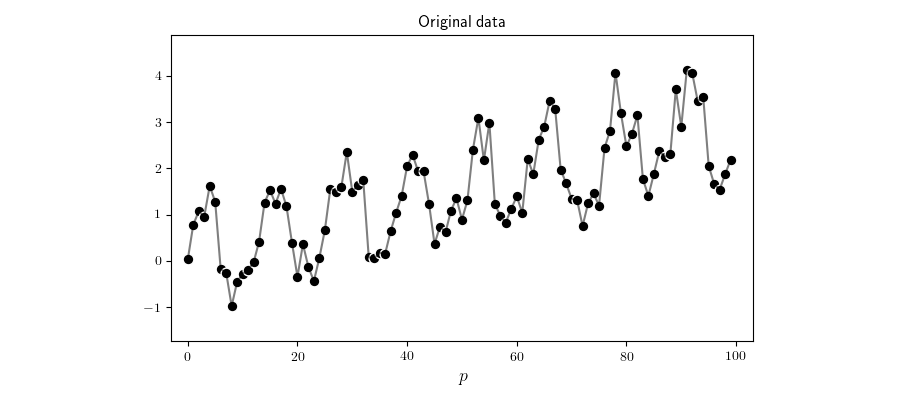
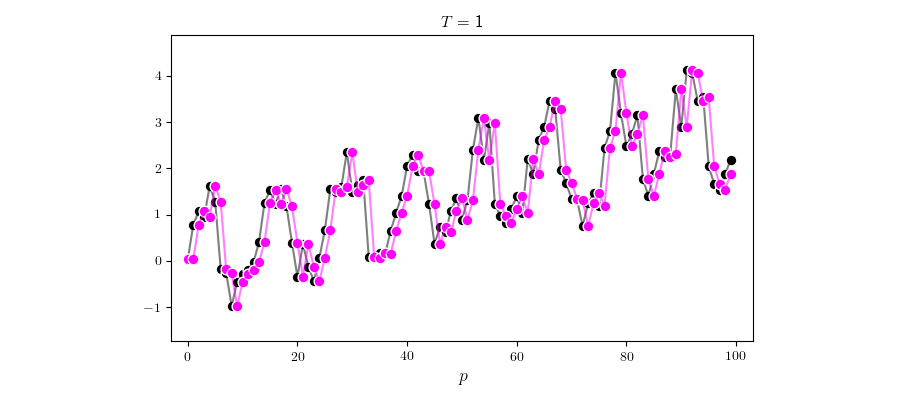
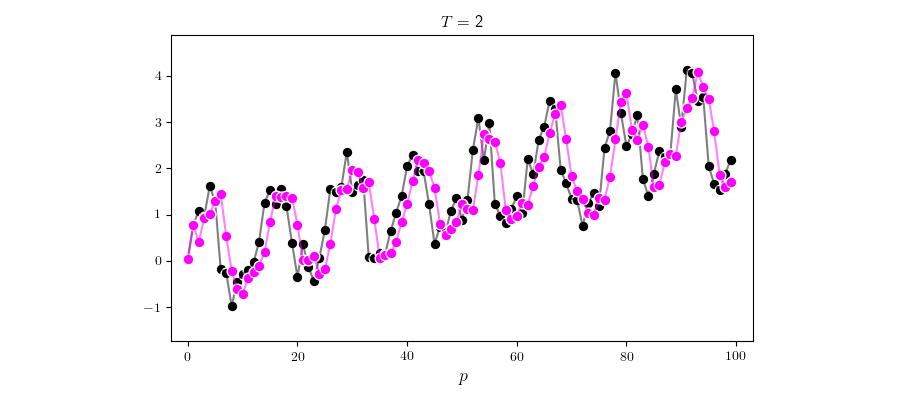
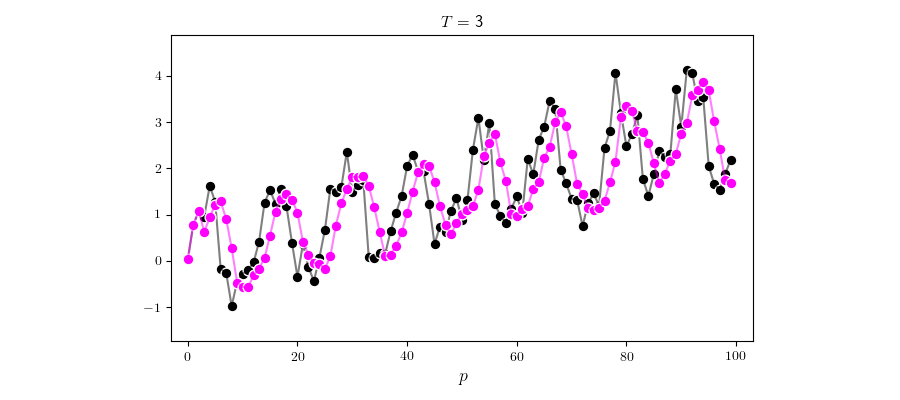
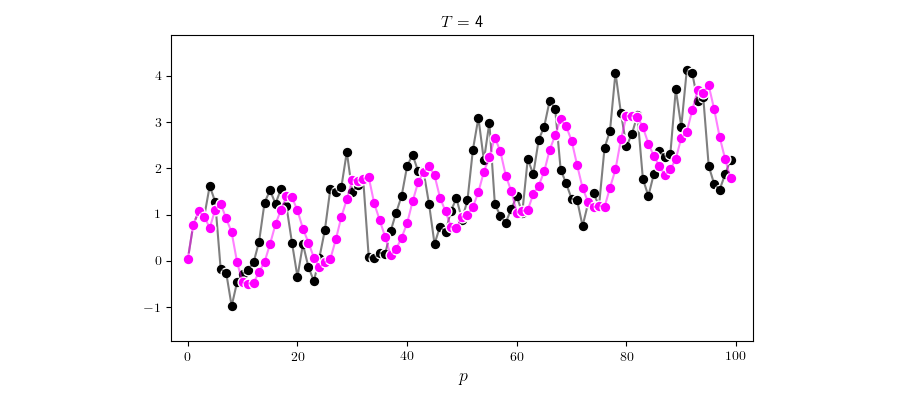
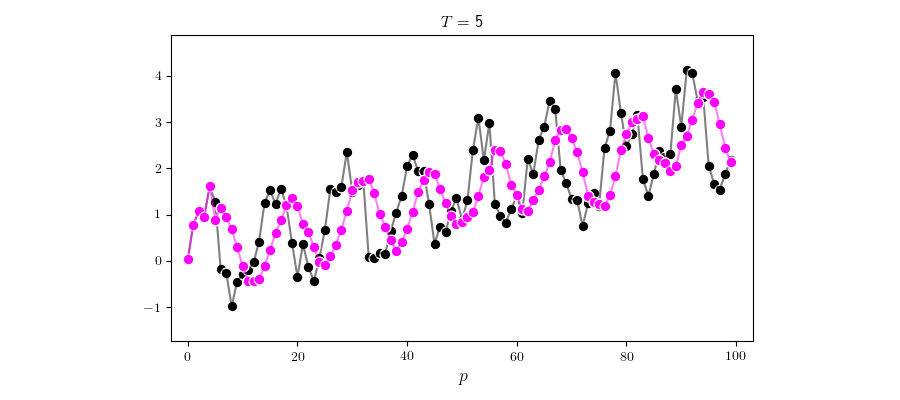
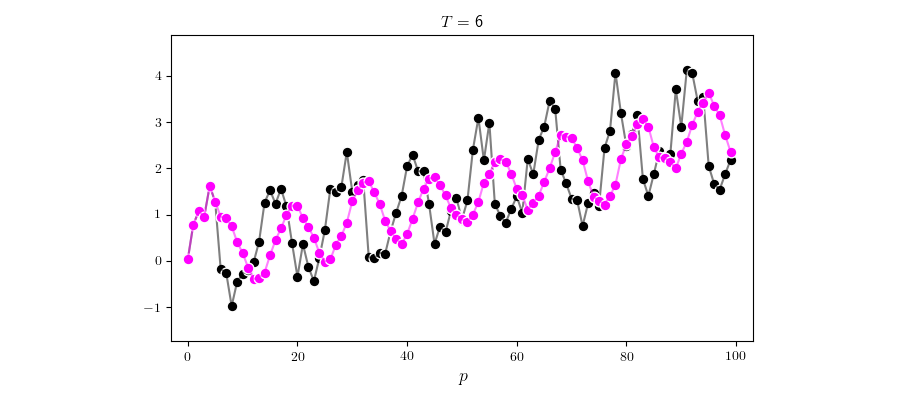
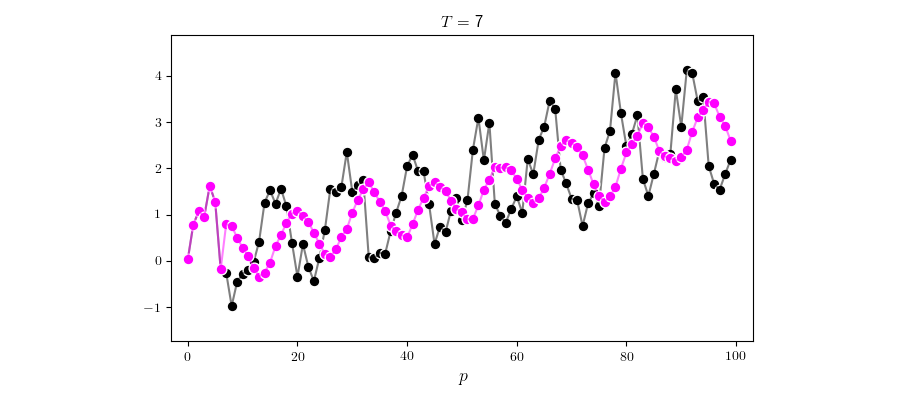
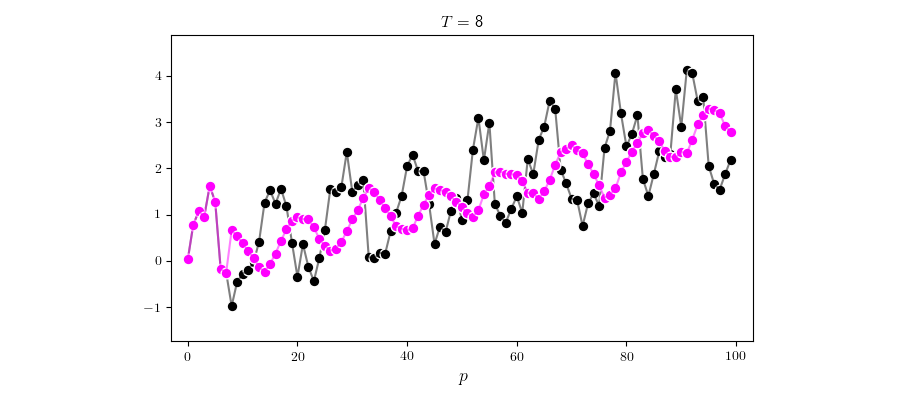
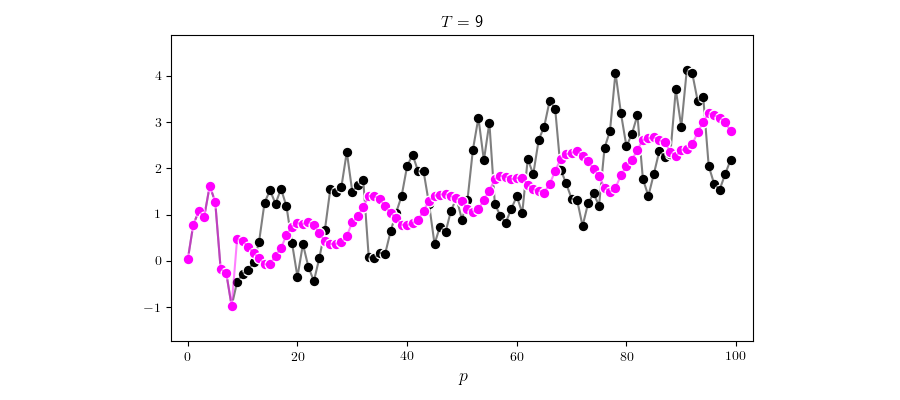
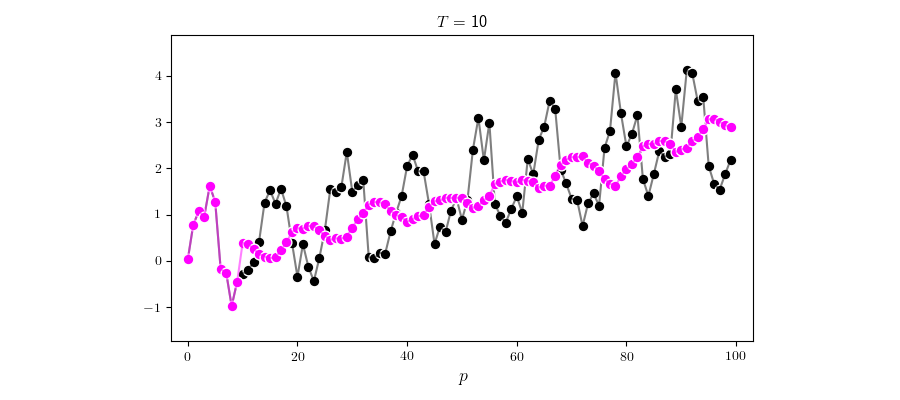
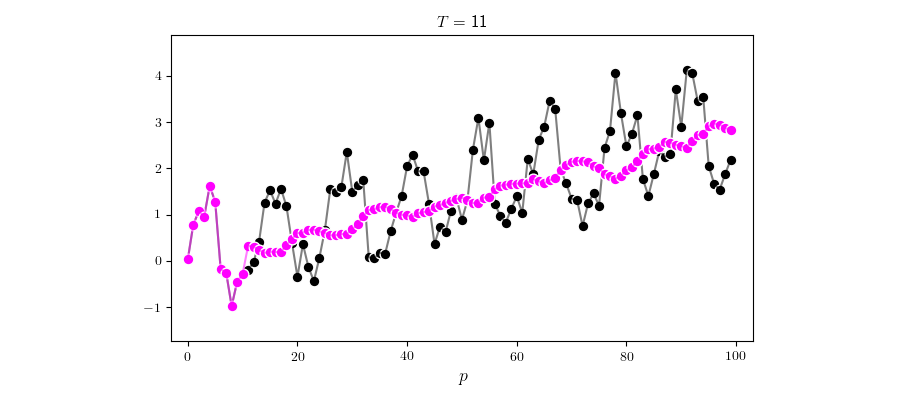
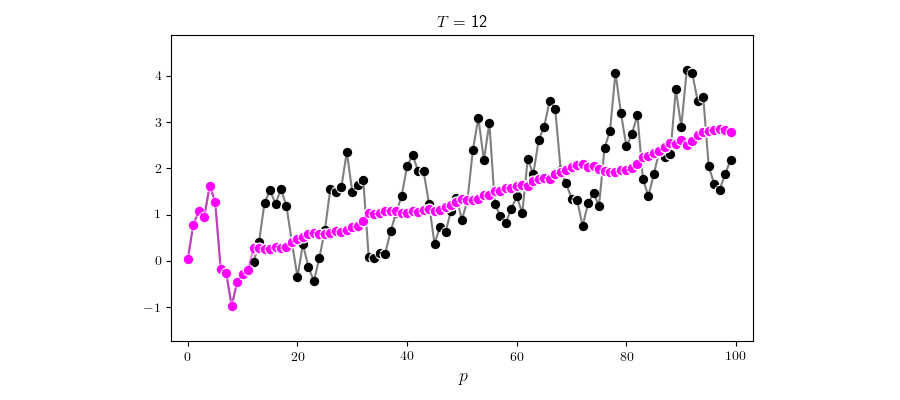
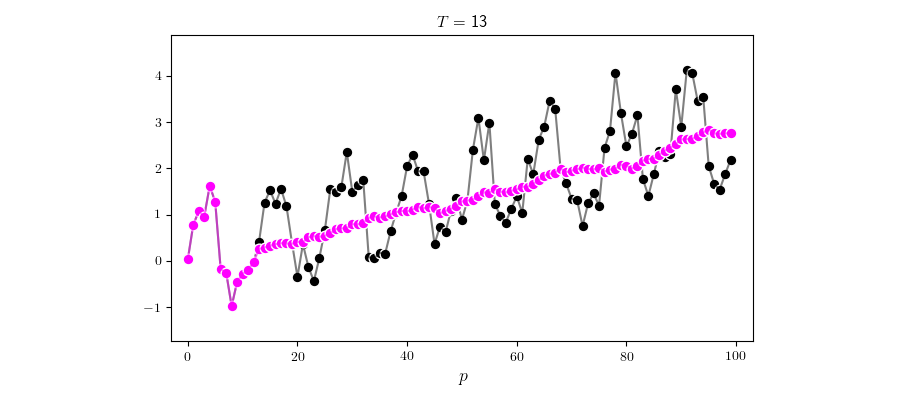
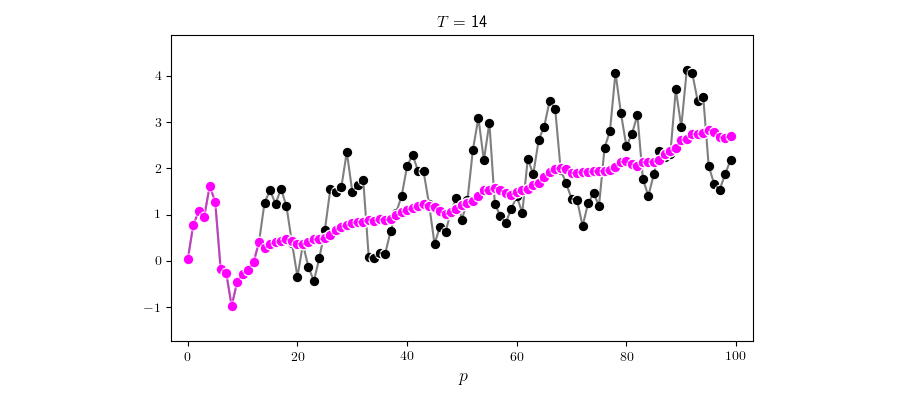
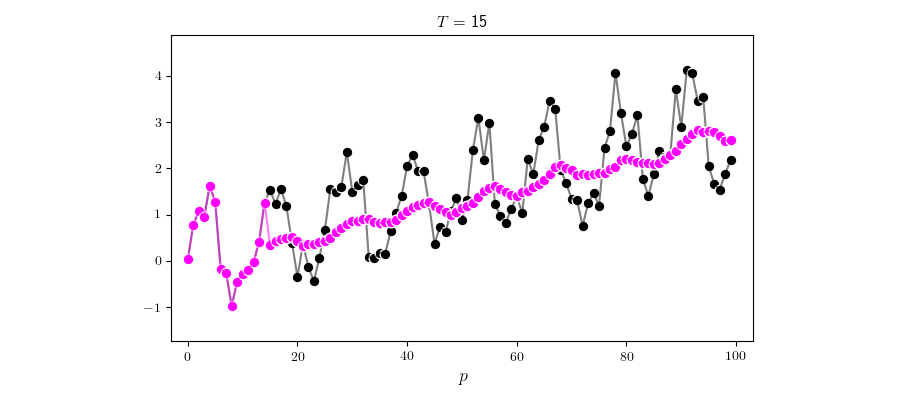
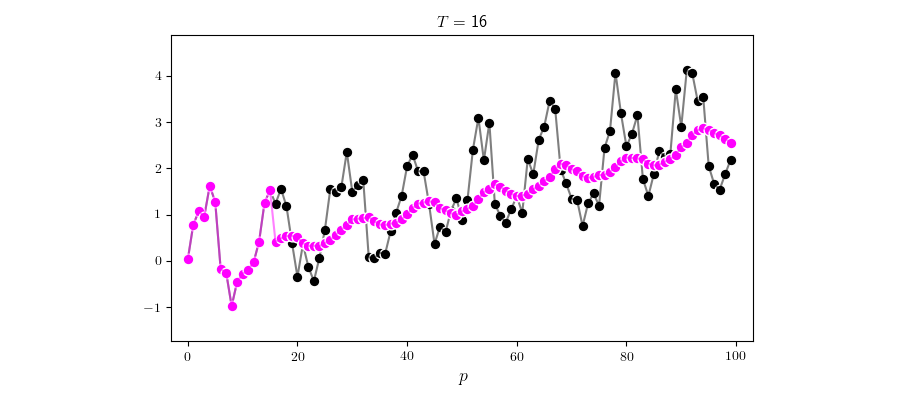
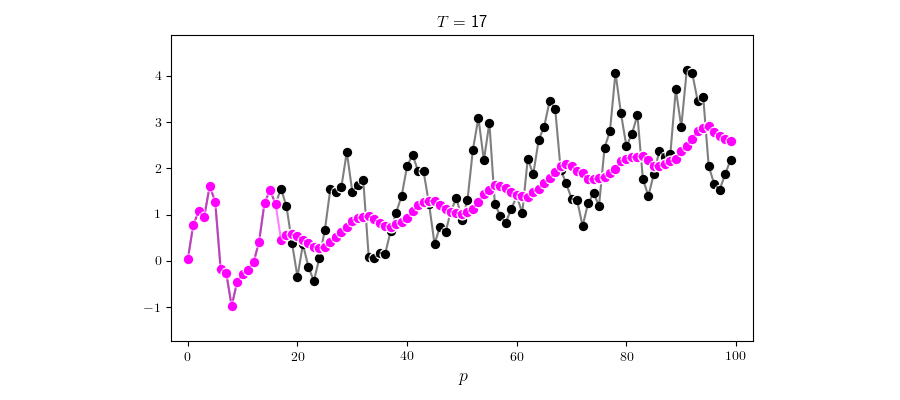
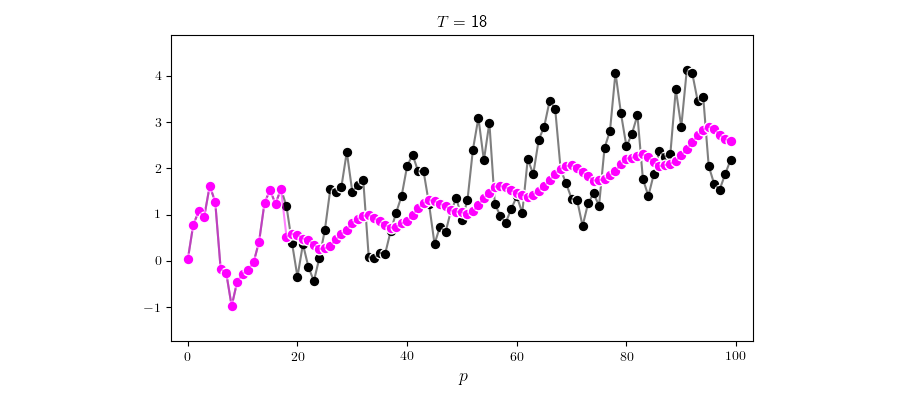
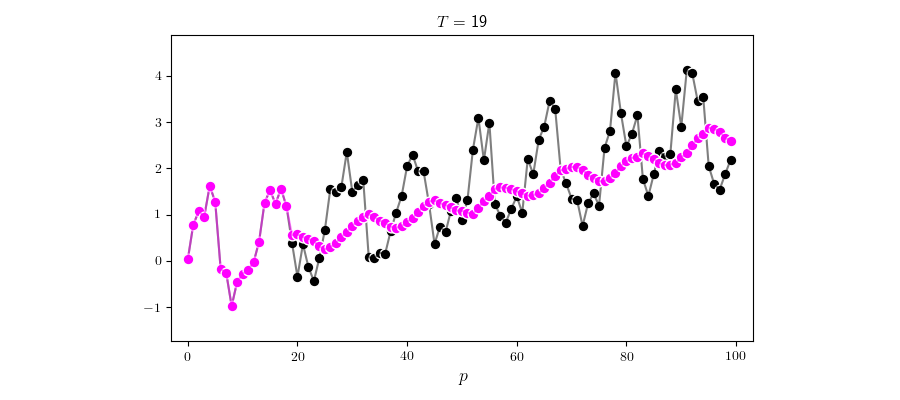
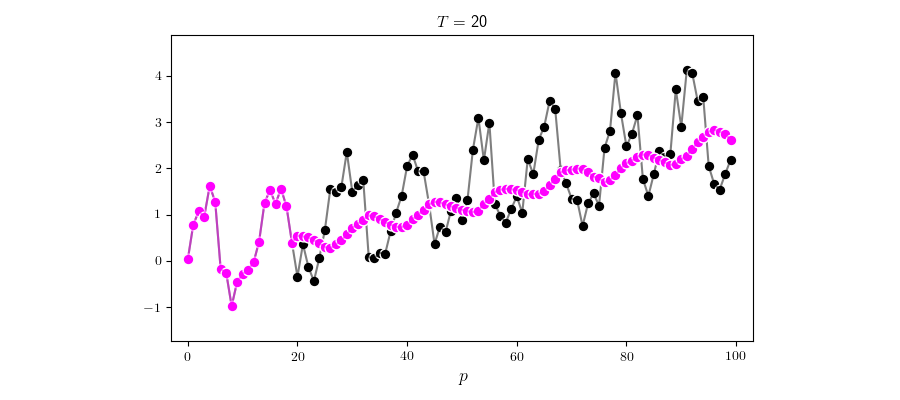

In [21]:
## This code cell will not be shown in the HTML version of this notebook
# moving average function
def moving_average(x,T):
    y = [v for v in x[:T]]
    for i in range(len(x) - T):
        # make next element
        b = np.sum(x[i:i+T])/float(T)
        y.append(b)
    return y

### generate x ###
x = []
num_elements = 100
for i in range(num_elements):
    xn = np.sin(0.5*i) + 0.4*np.random.randn(1) + 0.03*i
    x.append(xn)
    
demo = recurlib.time_series_animators.Visualizer()
params = np.arange(1,21)
demo.animate_1d_series(x,moving_average,params)